In [2]:
# Imports

from surfacecode.logical_qubit import LQubit
from surfacecode.circuits import SquareLattice
from surfacecode.lattice import *
from surfacecode.simulators import *
from surfacecode.surface import *
from surfacecode.mwpm import ParityCheckMatrix, ErrorCorrection

from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error, amplitude_damping_error, phase_damping_error)
from qiskit_ibm_provider import IBMProvider, least_busy

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# Z-cut

## Initialize in X basis and perform Z gate (circle gate)

In [3]:
# Define square lattice width and height
WIDTH, HEIGHT = 3, 13
l = (7, 31)

# Create square lattice space and create logical qubit in this space using the "difficult" method
# This means that a Z-cut LQ is initialized in the X basis
lattice = SquareLattice(WIDTH, HEIGHT)
qubit = LQubit(lattice, l[0], l[1], True)
cycle = SurfaceCodeCycle(lattice)
num_qubits = WIDTH * HEIGHT

In [4]:
# Defined the logical circuit
qc = ConstrainedQuantumCircuit(lattice, WIDTH * HEIGHT)
qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(num_qubits)))

qc.add_register(ClassicalRegister(num_qubits + len(qubit.route(l[0],l[1])) // 2))
qc = qc.compose(qubit.alt_initialize(cycle), list(range(num_qubits)), list(range(num_qubits, 2 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(2 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 3 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc = qc.compose(qubit.circle_gate())

qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(3 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 4 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc.add_register(ClassicalRegister(4))
qc = qc.compose(qubit.alt_measure(), list(range(num_qubits)), list(range(4 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 4 * num_qubits + len(qubit.route(l[0],l[1])) // 2 + 4)))

## Simulation

In [10]:
# Example of creating depolarizing noise models
noise_model = NoiseModel()
error = depolarizing_error(0.6, 1)
noise_model.add_all_qubit_quantum_error(error, ['x', 'z', 'h'])
print(noise_model)

aersim = AerSimulator(method="stabilizer", noise_model=noise_model)
built = transpile(qc, aersim)
job = aersim.run(built, shots=1000)
result = job.result()
result

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x', 'z']
  Instructions with noise: ['x', 'h', 'z']
  All-qubits errors: ['x', 'z', 'h']


Result(backend_name='aer_simulator', backend_version='0.13.2', qobj_id='', job_id='a184fc6c-4b07-4b47-bcaf-4a8f4815f00c', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0xc04411140402822a828a000441000438200228000': 1, '0xe104445141008aa0a008051000450000220020a08': 1, '0x10051444050208280280011450040468008a08020': 1, '0xb1441451050288000882000440441428028208808': 1, '0xe005415001008a82a202050401051408a08a20a20': 1, '0xb0414510450000822080011011041040008a28008': 1, '0x41414011410080888200001401051070228028020': 1, '0xd1014050414082a88208040411401040200a20a20': 1, '0x3000104401420a282a88011051050420808208220': 1, '0xc041500541028888000a041000401048828200000': 1, '0x41014015450288a88882041450450428028800828': 1, '0x81005551004088a28a82001001440030a08008008': 1, '0x14515000442082a828a010011441450808a28a20': 1, '0x71044400450008a00a82050400411070000a20a00': 1, '0x804511454542880aa888050440041008028008000': 1, '0xe10541114000

In [11]:
# Function that parses the job results and returns a list of cycles where each cycle only contains the measurements from the stabilizers.
def cycles(key: str, num_stabilizers: int, width: int, height: int):
    cycles = key.split(" ")[1:]
    sep_cycles = []
    for cycle in cycles:
        cycle = cycle[:width * height]
        j = 1
        z_measures = []
        x_measures = []
        for i, measure in enumerate(cycle):
            if i >= width * j:
                j += 1
            if i % 2 == 1:
                if j % 2 == 1:
                    z_measures.append(int(measure))
                else:
                    x_measures.append(int(measure))
                    
        sep_cycle = np.concatenate([np.array(z_measures), np.array(x_measures)])
        sep_cycle = np.array(sep_cycle).reshape(1, -1)
        sep_cycles.append(sep_cycle)

    sep_cycles = np.concatenate(sep_cycles)
    return sep_cycles

In [33]:
# Define the range of noise error rate to simulated on
noise_ps = np.linspace(0, 0.2, 50)
# List of fn, fp, tn, tp
# Fp is when the measurement was correct but then the algorithm makes it wrong
# Fn is when the measurement was wrong but then the algorithm makes it right
# Tn is when the measurement was wrong but then the algorithm doesn't detect the error
# Tp is when the measurement was correct but then the algorithm doesn't do anything which is good

fns, fps, tns, tps = [], [], [], []

# For each error rate value in noise_ps
for noise_p in tqdm(noise_ps):
    # Define depolarizing noise with this error rate
    noise_model = NoiseModel()
    error = depolarizing_error(noise_p, 1)
    noise_model.add_all_qubit_quantum_error(error, ['x', 'z', 'h'])

    # Run the simulation
    aersim = AerSimulator(method="stabilizer", noise_model=noise_model)
    built = transpile(qc, aersim)
    job = aersim.run(built, shots = 5000)
    result = job.result()
    shots = result.get_counts()


    fn, fp, tn, tp = 0, 0, 0, 0

    # Goes through the results apply perfect matching and count the fn, fp, tn, tp
    for shot in list(shots.keys()):
        counts = shots[shot]
        # Call cycles function to return a list of cycles
        a = cycles(shot, lattice.z_counter + lattice.x_counter, WIDTH, HEIGHT)

        # Perform perfect matching things
        parity = ParityCheckMatrix(lattice.z_counter + lattice.x_counter, len(lattice.nodes) - lattice.z_counter - lattice.x_counter)
        mm = parity._populate(lattice)
        correction = ErrorCorrection(parity)
        b = correction.analyze(np.array(list(reversed(a))[2:]))
        
        if b[5] ^ b[8] ^ b[11] ^ b[14]:
            a1, a2, a3, a4 = int(shot[0]), int(shot[1]), int(shot[2]), int(shot[3])
            x1 = a1 ^ a2 ^ a3 ^ a4
            b1, b2, b3, b4 = int(shot[127]), int(shot[126]), int(shot[125]), int(shot[124])
            x2 = b1 ^ b2 ^ b3 ^ b4
            x3 = x1 ^ x2
            if x3:
                fn += counts
            else:
                fp += counts
        else:
            a1, a2, a3, a4 = int(shot[0]), int(shot[1]), int(shot[2]), int(shot[3])
            x1 = a1 ^ a2 ^ a3 ^ a4
            b1, b2, b3, b4 = int(shot[127]), int(shot[126]), int(shot[125]), int(shot[124])
            x2 = b1 ^ b2 ^ b3 ^ b4
            x3 = x1 ^ x2
            if x3:
                tn += counts
            else:
                tp += counts

    fns.append(fn)
    fps.append(fp)
    tns.append(tn)
    tps.append(tp)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:38<00:00,  6.76s/it]


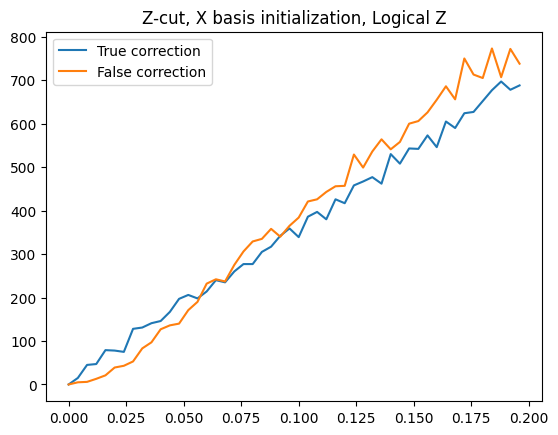

In [ ]:
ids = np.arange(0, 0.3, 0.3/50)

plt.title("Z-cut, X basis initialization, Logical Z")
plt.plot(ids, np.array(fns), label="True correction")
plt.plot(ids, np.array(fps), label="False correction")
plt.legend()

## Initialize in X-basis and perform X gate (line gate)

In [76]:
# Defined the logical circuit
qc = ConstrainedQuantumCircuit(lattice, WIDTH * HEIGHT)
qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(num_qubits)))

qc.add_register(ClassicalRegister(num_qubits + len(qubit.route(l[0],l[1])) // 2))
qc = qc.compose(qubit.alt_initialize(cycle), list(range(num_qubits)), list(range(num_qubits, 2 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(2 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 3 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc = qc.compose(qubit.line_gate())

qc.add_register(ClassicalRegister(num_qubits))
qc = qc.compose(cycle._circuit(1), list(range(num_qubits)), list(range(3 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 4 * num_qubits + len(qubit.route(l[0],l[1])) // 2)))

qc.add_register(ClassicalRegister(4))
qc = qc.compose(qubit.alt_measure(), list(range(num_qubits)), list(range(4 * num_qubits + len(qubit.route(l[0],l[1])) // 2, 4 * num_qubits + len(qubit.route(l[0],l[1])) // 2 + 4)))

## Simulation

In [21]:
# Define the range of noise error rate to simulated on
noise_ps = np.linspace(0, 0.2, 50)
# List of fn, fp, tn, tp
# Fp is when the measurement was correct but then the algorithm makes it wrong
# Fn is when the measurement was wrong but then the algorithm makes it right
# Tn is when the measurement was wrong but then the algorithm doesn't detect the error
# Tp is when the measurement was correct but then the algorithm doesn't do anything which is good

fns, fps, tns, tps = [], [], [], []

# For each error rate value in noise_ps
for noise_p in tqdm(noise_ps):
    # Define depolarizing noise with this error rate
    noise_model = NoiseModel()
    error = depolarizing_error(noise_p, 1)
    noise_model.add_all_qubit_quantum_error(error, ['x', 'z', 'h'])

    # Run the simulation
    aersim = AerSimulator(method="stabilizer", noise_model=noise_model)
    built = transpile(qc, aersim)
    job = aersim.run(built, shots = 5000)
    result = job.result()
    shots = result.get_counts()


    fn, fp, tn, tp = 0, 0, 0, 0

    # Goes through the results apply perfect matching and count the fn, fp, tn, tp
    for shot in list(shots.keys()):
        counts = shots[shot]
        # Call cycles function to return a list of cycles
        a = cycles(shot, lattice.z_counter + lattice.x_counter, WIDTH, HEIGHT)

        # Perform perfect matching things
        parity = ParityCheckMatrix(lattice.z_counter + lattice.x_counter, len(lattice.nodes) - lattice.z_counter - lattice.x_counter)
        mm = parity._populate(lattice)
        correction = ErrorCorrection(parity)
        b = correction.analyze(np.array(list(reversed(a))[2:]))
        
        if b[5] ^ b[8] ^ b[11] ^ b[14]:
            a1, a2, a3, a4 = int(shot[0]), int(shot[1]), int(shot[2]), int(shot[3])
            x1 = a1 ^ a2 ^ a3 ^ a4
            b1, b2, b3, b4 = int(shot[127]), int(shot[126]), int(shot[125]), int(shot[124])
            x2 = b1 ^ b2 ^ b3 ^ b4
            x3 = x1 ^ x2
            if x3:
                fn += counts
            else:
                fp += counts
        else:
            a1, a2, a3, a4 = int(shot[0]), int(shot[1]), int(shot[2]), int(shot[3])
            x1 = a1 ^ a2 ^ a3 ^ a4
            b1, b2, b3, b4 = int(shot[127]), int(shot[126]), int(shot[125]), int(shot[124])
            x2 = b1 ^ b2 ^ b3 ^ b4
            x3 = x1 ^ x2
            if x3:
                tn += counts
            else:
                tp += counts

    fns.append(fn)
    fps.append(fp)
    tns.append(tn)
    tps.append(tp)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:37<00:00,  6.74s/it]


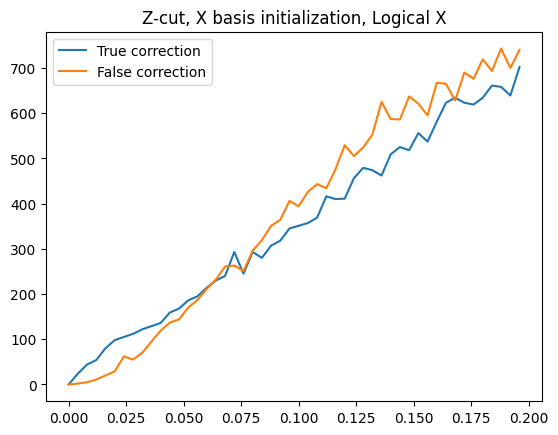

In [32]:
ids = np.arange(0, 0.3, 0.3/50)

plt.title("Z-cut, X basis initialization, Logical X")
plt.plot(ids, fns, label="True correction")
plt.plot(ids, fps, label="False correction")
plt.legend()